# 3D Instance Segmentation with Discriminative Instance Loss
---
Implemntation of paper:

[Semantic Instance Segmentation with a Discriminative Loss Function](https://arxiv.org/abs/1708.02551)

In [1]:
import os
import errno

import numpy as np

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Adam

from deepcell import make_training_data
from deepcell.model_zoo import bn_feature_net_3D, disc_net_3D
from deepcell.training import train_model_movie, train_model_disc_3D
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler

Using TensorFlow backend.


In [2]:
# data options
DATA_OUTPUT_MODE = 'conv'
PADDING = 'same'
RESIZE = True
RESHAPE_SIZE = 256
NUM_FRAMES = 15  # get first N frames from each training folder

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else -1

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
DATA_FILE = 'MouseBrain_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    dimensionality=3,
    window_size_x=30,
    window_size_y=30,
    window_size_z=2,
    padding=PADDING,
    file_name_save=os.path.join(NPZ_DIR, PREFIX, DATA_FILE),
    training_direcs=None,  # all training directories
    channel_names=[''],
    num_frames=NUM_FRAMES,
    num_of_features=2,  # Specify the number of feature masks that are present
    montage_mode=True,
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages',
    annotation_name='',  # basically channel name but for annotated images
    reshape_size=RESHAPE_SIZE if RESIZE else None,
    output_mode=DATA_OUTPUT_MODE)

Reshaped feature data from (220, 15, 256, 256, 1) to (220, 15, 256, 256, 1)
Reshaped training data from (220, 15, 256, 256, 1) to (220, 15, 256, 256, 1)


In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 20
batch_size = 1
frames_per_batch = 5
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

# save the size of the input data for batch_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    batch_shape = (batch_size, X.shape[CHANNEL_AXIS], frames_per_batch, size[0], size[1])
else:
    batch_shape = (batch_size, frames_per_batch, size[0], size[1], X.shape[CHANNEL_AXIS])

X.shape: (220, 15, 256, 256, 1)
y.shape: (220, 15, 256, 256, 1)


### Foreground/background model

In [5]:
# Instantiate the model
fgbg_model = bn_feature_net_3D(
    batch_shape=batch_shape,
    n_features=2,
    location=False,
    norm_method='whole_image')

# Train the model
train_model_movie(
    model=fgbg_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    frames_per_batch=frames_per_batch,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    expt='fgbg',
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (1, 5, 256, 256, 2)
Number of Classes: 2
Using real-time data augmentation.
Epoch 1/20
593/594 [============================>.] - ETA: 0s - loss: 0.1924 - acc: 0.9109
Epoch 00001: val_loss improved from inf to 0.16589, saving model to /data/models/cells/MouseBrain/generic/2018-08-25_MouseBrain_channels_last_conv_fgbg_0.h5
594/594 [==============================] - 225s 379ms/step - loss: 0.1923 - acc: 0.9110 - val_loss: 0.1659 - val_acc: 0.9405
Epoch 2/20
593/594 [============================>.] - ETA: 0s - loss: 0.1682 - acc: 0.9194
Epoch 00002: val_loss did not improve
594/594 [==============================] - 212s 357ms/step - loss: 0.1681 - acc: 0.9194 - val_loss: 0.1726 - val_acc: 0.9206
Epoch 3/20
593/594 [============================>.] - ETA: 0s - loss: 0.1640 - acc: 0.9209
Epoch 00003: val_loss did not improve
594/59

### 3D Vector Embedding

In [6]:
# Instantiate the model
disc_model_3d = disc_net_3D(
    batch_shape=batch_shape,
    norm_method='std',
    n_features=3,  # N-dimensional vector embedding
    location=True,
    seg_model=fgbg_model,
    softmax=False)

# Train the model
train_model_disc_3D(
    model=disc_model_3d,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    frames_per_batch=frames_per_batch,
    rotation_range=180,
    zoom_range=0,  # a float or a tuple/list of two floats
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (1, 5, 256, 256, 3)
Number of Classes: 3
Epoch 1/20
593/594 [============================>.] - ETA: 0s - loss: 6.0120
Epoch 00001: val_loss improved from inf to 4.95863, saving model to /data/models/cells/MouseBrain/generic/2018-08-25_MouseBrain_channels_last_conv__0.h5
594/594 [==============================] - 500s 842ms/step - loss: 6.0139 - val_loss: 4.9586
Epoch 2/20
593/594 [============================>.] - ETA: 0s - loss: 5.9958
Epoch 00002: val_loss improved from 4.95863 to 4.82907, saving model to /data/models/cells/MouseBrain/generic/2018-08-25_MouseBrain_channels_last_conv__0.h5
594/594 [==============================] - 489s 824ms/step - loss: 5.9937 - val_loss: 4.8291
Epoch 3/20
593/594 [============================>.] - ETA: 0s - loss: 5.9599
Epoch 00003: val_loss did not improve
594/594 [=======================

In [7]:
# With the trained model, make predictions on testing data
training_data_file_name = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')
train_dict, test_dict = get_data(training_data_file_name, mode='conv', seed=21)

X_test, y_test = test_dict

test_images = disc_model_3d.predict(X_test[:1, :frames_per_batch, :, :, :])
test_images_fgbg = fgbg_model.predict(X_test[:1, :frames_per_batch, :, :, :])

# threshold the foreground/background
# and remove background from vector embedding
fg_thresh = test_images_fgbg[:, :, :, :, 1] > 0.9
fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
test_images_post_fgbg = test_images * fg_thresh

print(test_images.shape)
print(test_images_fgbg.shape)
print(test_images_post_fgbg.shape)

(1, 5, 256, 256, 3)
(1, 5, 256, 256, 2)
(1, 5, 256, 256, 3)


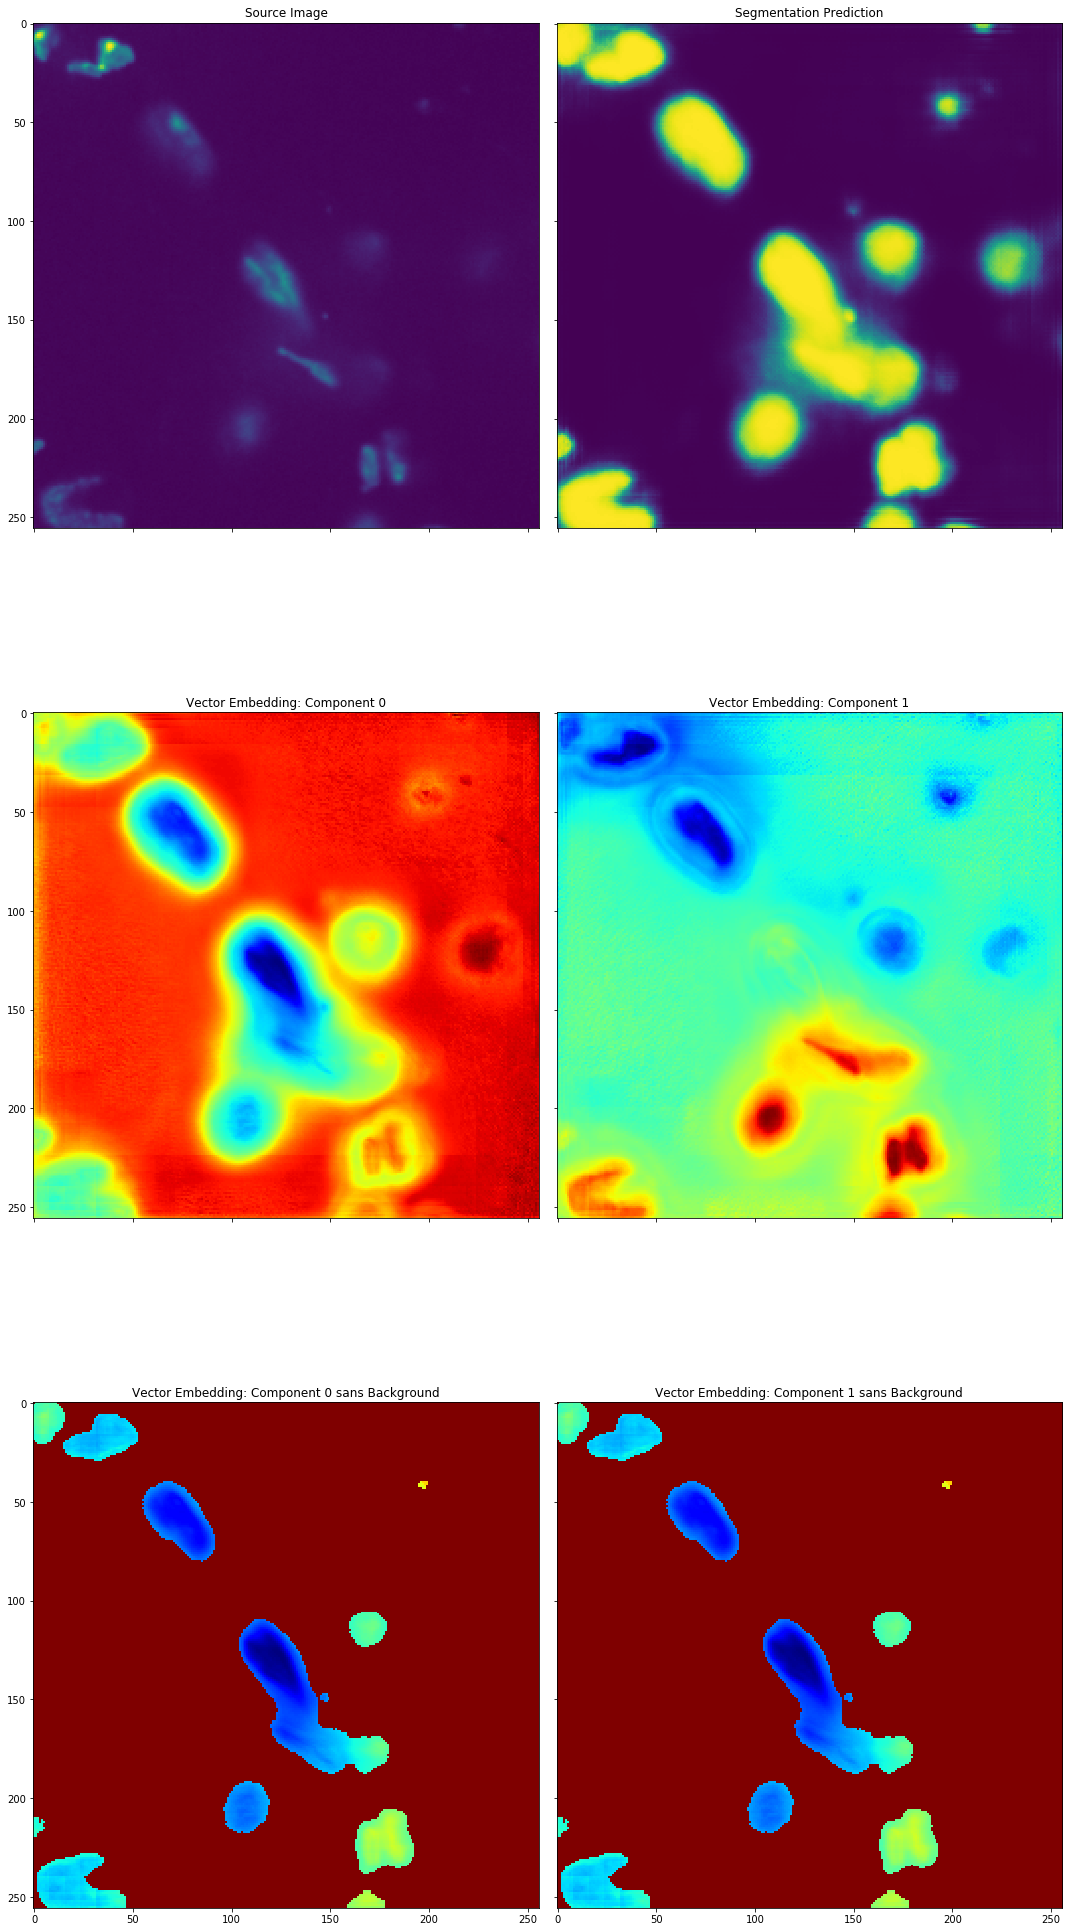

In [8]:
# Plot the results for 2D embedding
import matplotlib.pyplot as plt

index = 0
frame = 0

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 30), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(test_images[index, frame, :, :, 0], cmap='jet')
ax[2].set_title('Vector Embedding: Component 0')

ax[3].imshow(test_images[index, frame, :, :, 1], cmap='jet')
ax[3].set_title('Vector Embedding: Component 1')

ax[4].imshow(test_images_post_fgbg[index, frame, :, :, 0], cmap='jet')
ax[4].set_title('Vector Embedding: Component 0 sans Background')

ax[5].imshow(test_images_post_fgbg[index, frame, :, :, 0], cmap='jet')
ax[5].set_title('Vector Embedding: Component 1 sans Background')

# ms = fit_mean_shift(test_images_post_fgbg, index=index, ndim=2, n_samples=500)
# ax[6].imshow(ms.labels_.reshape(256, 256), cmap='jet')
# ax[6].set_title('MeanShift Clustering')

# db = fit_dbscan(test_images_post_fgbg, index=index, ndim=2, eps=0.12)
# ax[7].imshow(db.labels_.reshape(256, 256), cmap='jet')
# ax[7].set_title('DBSCAN Clustering')

fig.tight_layout()
plt.show()

In [9]:
from mpl_toolkits.mplot3d import Axes3D

batch = 0

test_plot_mean_shift = np.zeros_like(test_images_fgbg[batch, :, :, :, 0].reshape(-1, 256, 256))

# Mean Shift
from sklearn.cluster import MeanShift, estimate_bandwidth

for index in range(test_images_post_fgbg.shape[1]):
    test_plot = test_images_post_fgbg[batch, index, :, :, :].reshape(-1, 3)
    bandwidth = estimate_bandwidth(test_plot, n_samples=2000)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(test_plot)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    test_plot_mean_shift[index, :, :] = labels.reshape(256, 256)

    print("MeanShift - number of estimated clusters : %d" % n_clusters_)

MeanShift - number of estimated clusters : 18
MeanShift - number of estimated clusters : 20
MeanShift - number of estimated clusters : 24
MeanShift - number of estimated clusters : 22
MeanShift - number of estimated clusters : 20


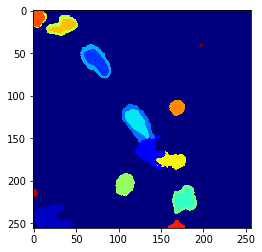

In [10]:
plt.imshow(test_plot_mean_shift[0, :, :], cmap='jet')

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images):
    fig = plt.figure()

    ims = []
    for i in range(images.shape[0]):
        im = plt.imshow(images[i, :, :], animated=True, cmap='jet')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
    return HTML(ani.to_jshtml())

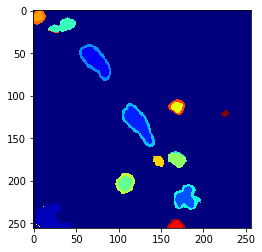

In [12]:
get_js_video(test_plot_mean_shift)

In [13]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

batch = 0

test_plot_dbscan = np.zeros_like(test_images_fgbg[batch, :, :, :, 0].reshape(-1, 256, 256))

for index in range(test_images_post_fgbg.shape[1]):
    test_plot = test_images_post_fgbg[batch, index, :, :, :].reshape(-1, 3)

    db = DBSCAN(eps=0.15, min_samples=5, algorithm='kd_tree').fit(test_plot)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    test_plot_dbscan[index] = labels.reshape(256, 256)

    print('DBSCAN - Estimated number of clusters: %d' % n_clusters_)


DBSCAN - Estimated number of clusters: 12
DBSCAN - Estimated number of clusters: 12
DBSCAN - Estimated number of clusters: 12
DBSCAN - Estimated number of clusters: 12
DBSCAN - Estimated number of clusters: 13


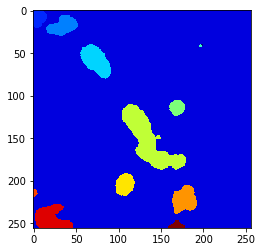

In [14]:
plt.imshow(test_plot_dbscan[0, :, :], cmap='jet')

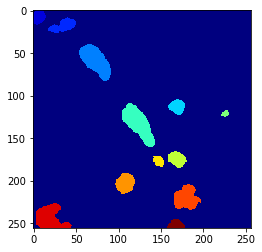

In [15]:
get_js_video(test_plot_dbscan)

In [ ]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

batch = 0

test_plot = test_images_post_fgbg[batch, :, :, :, :].reshape(-1, 3)

db = DBSCAN(eps=0.15, min_samples=5, algorithm='kd_tree').fit(test_plot)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
test_plot_dbscan = labels.reshape(-1, 256, 256)

print('DBSCAN - Estimated number of clusters: %d' % n_clusters_)

In [ ]:
get_js_video(test_plot_dbscan)